# Scaling up GNNs with GraphSAGE

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(-1)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Pubmed

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]
print(data)
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [3]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10], # Neighbor Sampling : 첫번째 이웃은 5개, 두번째 이웃은 10개 ##
    batch_size=16,         # Train Node의 개수 60개에 대하여 16개의 배치 사이즈 ==> 4개의 배치 단위(Sub Graph)
    input_nodes=data.train_mask, # 학습 데이터
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')
    # Data x= [Node개수, feature 차원], edge_index=[edge차원(start,end), 개수], y=[노드 개수], train_mask=[학습 Node 개수], val_mask=[평가 노드 개수], test_mask=[테스트 노드], input_id=[sub_graph의 입력 노드 수], batch_size=배치크기

Subgraph 0: Data(x=[419, 500], edge_index=[2, 464], y=[419], train_mask=[419], val_mask=[419], test_mask=[419], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[268, 500], edge_index=[2, 311], y=[268], train_mask=[268], val_mask=[268], test_mask=[268], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[289, 500], edge_index=[2, 324], y=[289], train_mask=[289], val_mask=[289], test_mask=[289], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[189, 500], edge_index=[2, 225], y=[189], train_mask=[189], val_mask=[189], test_mask=[189], input_id=[12], batch_size=12)


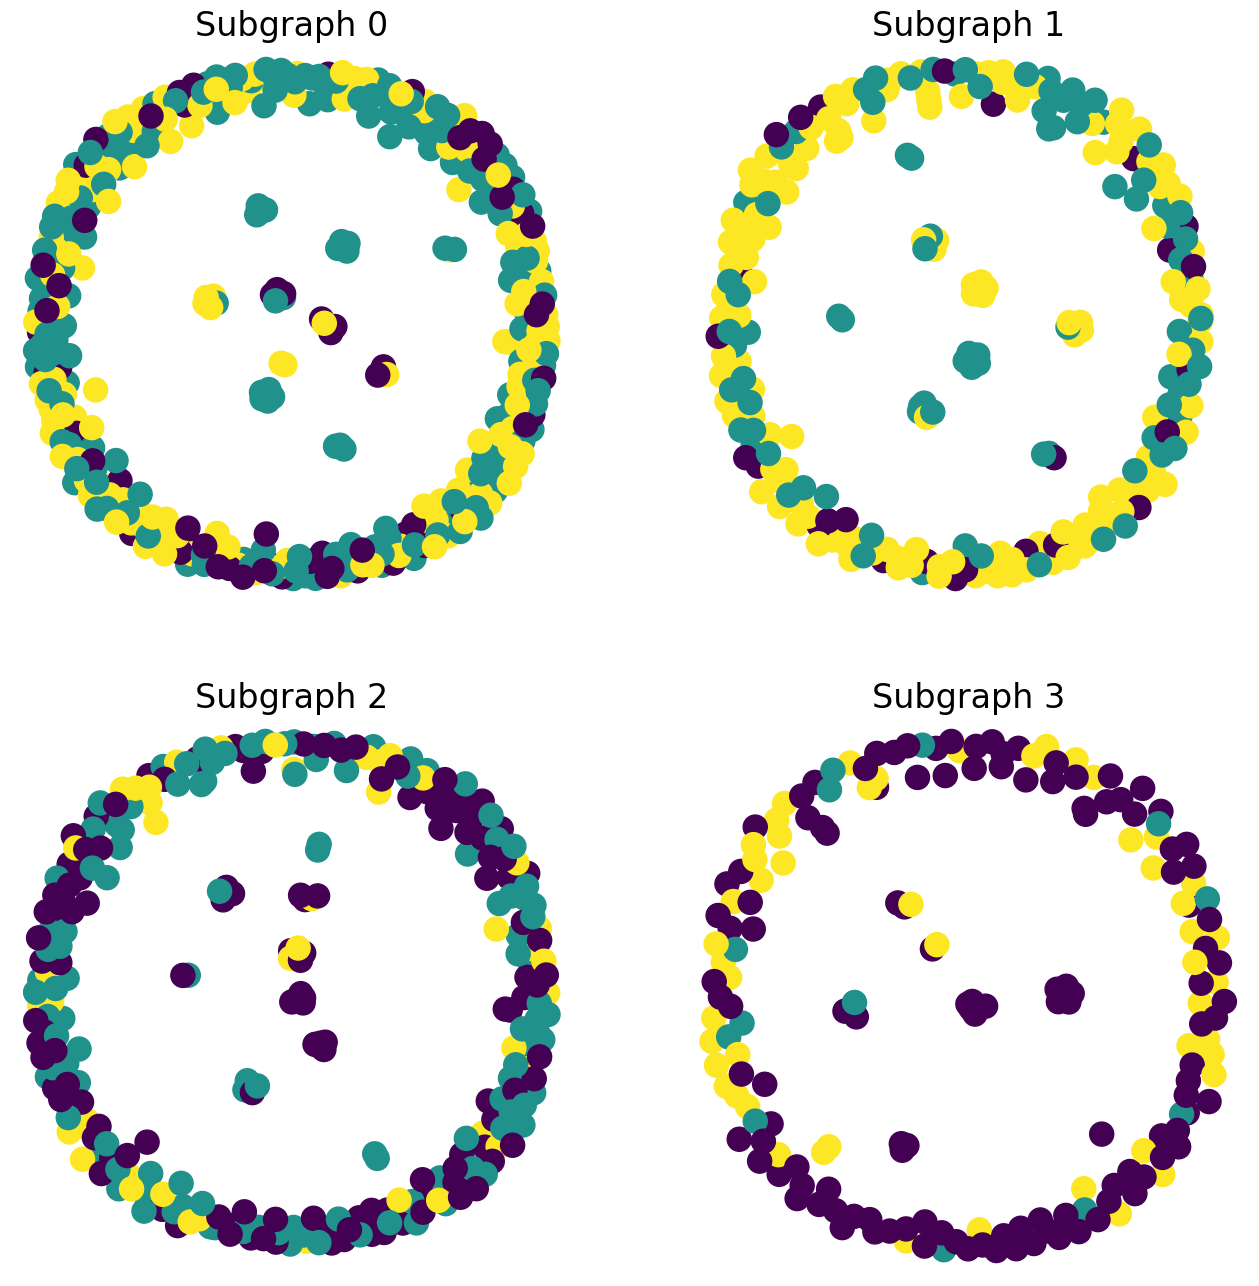

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])): # pos값은 row, col, index 순으로 이루어짐 ==> 2*2에 1,2,3,4 index
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

# GraphSAGE


*   SAGEConv => SAGEConv(in_feats, out_feats, aggr) / aggr = "mean" | "lstm" | "max"
*   ReLU => torch.relu()
*   dropout => F.dropout(input, p, training=self.training)



In [9]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


def accuracy(pred_y, y):
    """정확도 계산."""
    return ((pred_y == y).sum() / len(y)).item()


class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        # Layer 구성##
        self.sage1= SAGEConv(dim_in, dim_h, aggr='mean')
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        # forward code##
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h,edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            print(f'Epoch {epoch:>3} | Train Loss: {loss/len(loader):.3f} | Train Acc: {acc/len(loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [10]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(train_loader, 20)

# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.337 | Train Acc:  30.08% | Val Loss: 1.12 | Val Acc: 18.75%
Epoch   1 | Train Loss: 0.311 | Train Acc:  44.73% | Val Loss: 1.10 | Val Acc: 28.12%
Epoch   2 | Train Loss: 0.289 | Train Acc:  53.28% | Val Loss: 1.08 | Val Acc: 29.76%
Epoch   3 | Train Loss: 0.267 | Train Acc:  76.13% | Val Loss: 1.04 | Val Acc: 50.83%
Epoch   4 | Train Loss: 0.224 | Train Acc:  94.44% | Val Loss: 1.00 | Val Acc: 63.64%
Epoch   5 | Train Loss: 0.153 | Train Acc:  95.83% | Val Loss: 0.90 | Val Acc: 90.45%
Epoch   6 | Train Loss: 0.102 | Train Acc:  97.92% | Val Loss: 0.84 | Val Acc: 82.08%
Epoch   7 | Train Loss: 0.083 | Train Acc:  96.51% | Val Loss: 0.85 | Val Acc: 75.63%
Epoch   8 | Train Loss: 0.049 | Train Acc:  97.92% | Val Loss: 0.75 | Val Acc: 73.33%
Epoch   9 | Train Loss: 0.025 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 89.58%
Epoch  10 | Train Loss: 0.040 | Train Acc: 100.00

## PPI

Inductive Representation Learning을 위한 데이터 셋<br>
그래프에서 이웃 노드의 정보를 집계하여 단백질 간의 복잡한 관계와 상호 작용을 효과적으로 포착할 수 있습니다. Label이 붙은 단백질 상호작용 그래프에 대해 훈련되었습니다. 여기서 노드 Feature는 각 단백질의 특성을 나타내고 가장자리는 단백질 간의 상호작용을 나타냅니다.
<br>
모델의 Train Data에 존재하지 않는 단백질의 클래스를 예측 하기 때문에 Inductive Setting에서의 학습임.

In [ ]:
import torch
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load training, evaluation, and test sets
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

# Unify the training graphs and apply neighbor sampling
train_data = Batch.from_data_list(train_dataset)
train_loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)

# Evaluation loaders (one datapoint corresponds to a graph)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2, # Number of message passing layers.
    out_channels=train_dataset.num_classes,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit(loader):
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(loader.data)

@torch.no_grad()
def test(loader):
    model.eval()

    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

for epoch in range(20):
    loss = fit(train_loader)
    val_f1 = test(val_loader)
    print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1-score: {val_f1:.4f}')

print(f'Test F1-score: {test(test_loader):.4f}')

Extracting ./ppi.zip
Processing...
Done!
